# Clustering de documents

## Imports

In [77]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [78]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Zack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [79]:
data_path = "../../data/txt/"

## Choisir une décennie

In [80]:
DECADE = '1900'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [81]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [82]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

## Vectoriser les documents à l'aide de TF-IDF

In [83]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [84]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [ ]:
tfidf_vectors = vectorizer.fit_transform(texts)

d:\Cours_ULB\Traitement automatique de Corpus\tac\tac_venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Imprimer le vecteur tf-IDF du premier document

In [ ]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

janvier       0.289538
président     0.216835
dépêche       0.182931
anglaises     0.152959
guerre        0.143314
                ...   
découvert     0.000000
découverte    0.000000
découvrir     0.000000
décès         0.000000
♦             0.000000
Length: 3942, dtype: float64

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

### Définir un nombre de clusters

In [ ]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [ ]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [ ]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA

In [ ]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Générer le plot

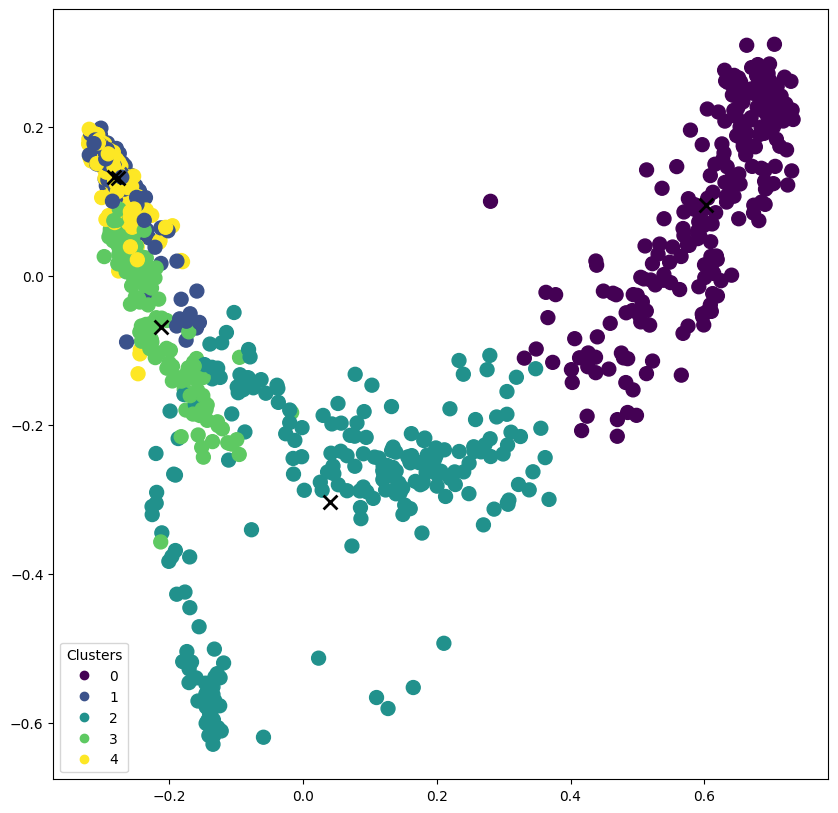

In [ ]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Word Embeddings : le modèle Word2Vec

## Imports

In [ ]:
import sys

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode

## Chargement et traitement des phrases du corpus

### Création d'un objet qui *streame* les lignes d'un fichier pour économiser de la RAM

In [ ]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [ ]:
infile = f"../../data/sents.txt"
sentences = MySentences(infile)

### Détection des bigrams

In [ ]:
bigram_phrases = Phrases(sentences)

### Conversion des `Phrases` en objet `Phraser`

In [ ]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

### Extraction des trigrams

In [ ]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [ ]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [ ]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

## Entrainement d'un modèle Word2Vec sur ce corpus

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=15, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.
)

CPU times: total: 2min 44s
Wall time: 1min 4s


### Sauver le modèle dans un fichier

In [ ]:
outfile = f"../../data/newspapers.model"
model.save(outfile)

## Explorer le modèle

### Charger le modèle en mémoire

In [ ]:
model = Word2Vec.load("../../data/newspapers.model")

## Imprimer le vecteur du terme _ministre_

In [ ]:
model.wv["ministre"]

array([-4.512713  ,  4.30494   ,  0.16215032,  5.4625416 , -1.2364147 ,
       -1.3799545 ,  0.1340706 , -2.6636412 ,  0.855826  , -3.6148486 ,
        3.3094208 ,  5.910727  , -1.0245494 ,  1.2325633 , -0.9362983 ,
       -3.3061721 , -1.6140995 , -0.8971235 , -1.4844903 ,  1.7873639 ,
        3.4246671 ,  1.3251307 ,  1.7753689 , -2.561189  , -1.4307963 ,
       -0.50895554, -0.05886241, -0.28513896, -0.23174064,  0.1865668 ,
        0.893943  ,  4.122026  ], dtype=float32)

### Calculer la similarité entre deux termes

In [ ]:
model.wv.similarity("ministre", "roi")

0.52988154

### Chercher les mots les plus proches du terme _ministre_

In [ ]:
model.wv.most_similar("ministre", topn=10)

[('president', 0.8640021085739136),
 ('secretaire', 0.863402247428894),
 ('membre', 0.858784556388855),
 ('conseiller', 0.8375511765480042),
 ('buis', 0.8347923159599304),
 ('bourgmestre', 0.8203409314155579),
 ('secretaire_general', 0.8138335347175598),
 ('ancien_ministre', 0.8138312697410583),
 ('depute', 0.8137232661247253),
 ('la_presidence', 0.8126429319381714)]

## Imprimer le vecteur du terme _Bruxelles_

In [ ]:
model.wv["bruxelles"]

array([-1.1631608 , -4.1996264 , -6.2887383 ,  4.2104955 , -0.25585228,
       -3.0909185 , -4.877991  , -5.780832  , -2.7372227 , -4.1846576 ,
        2.9479387 , -1.1939029 , -1.832152  ,  1.7057227 ,  0.76057667,
       -0.6821538 , -0.4869225 , -0.7914881 , -0.0875438 , -2.495335  ,
        1.5810773 ,  2.575361  , -2.7734306 , -7.0350266 ,  3.9560935 ,
        1.1087713 , -0.11215068,  0.47085014,  1.3244356 ,  3.0318289 ,
       -5.688136  ,  2.217621  ], dtype=float32)

### Calculer la similarité entre deux termes

In [ ]:
model.wv.similarity("bruxelles", "paris")

0.6035382

### Chercher les mots les plus proches d'un terme donné

In [ ]:
model.wv.most_similar("bruxelles", topn=10)

[('des_ventes', 0.7911458611488342),
 ('notaires', 0.7516762018203735),
 ('ventes', 0.7510043382644653),
 ('par_notaires', 0.7502731084823608),
 ('salle_des_ventes', 0.7456029653549194),
 ('spa', 0.7448025941848755),
 ('ventes_par_notaires', 0.7442269921302795),
 ('adjudication_definitive', 0.7408488988876343),
 ('location_publique', 0.7362392544746399),
 ('la_salie', 0.7351745963096619)]

## Imprimer le vecteur du terme _appartement_

In [ ]:
model.wv["appartement"]

array([-0.0228594 , -1.5499139 ,  0.17891718,  1.050072  , -0.15001653,
        1.0001894 , -1.9607751 , -0.8943315 ,  0.533201  ,  1.8221928 ,
        2.534982  , -0.969731  , -1.5026472 ,  1.6171747 , -2.2206953 ,
        1.0497959 ,  4.455437  , -0.70944583,  2.1475763 , -2.3828108 ,
       -1.8110912 ,  0.848051  ,  1.5051523 ,  2.0027902 ,  1.247337  ,
       -1.0709587 , -2.5737786 , -1.0079304 , -0.4631492 , -0.60936505,
       -0.34143195,  1.668567  ], dtype=float32)

### Calculer la similarité entre deux termes

In [ ]:
model.wv.similarity("appartement", "maison")

0.55150795

### Chercher les mots les plus proches du terme _ministre_

In [ ]:
model.wv.most_similar("appartement", topn=10)

[('etage', 0.8603399991989136),
 ('meuble', 0.848802387714386),
 ('4_places', 0.8475049138069153),
 ('villa', 0.8462846279144287),
 ('ecurie', 0.8268498182296753),
 ('pouvant_servir', 0.8010918498039246),
 ('balcon', 0.7861953973770142),
 ('tout_confort', 0.7847655415534973),
 ('mansarde', 0.7845688462257385),
 ('2_places', 0.7811166048049927)]